In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import mynn 
from draw_tools.plot import plot
from struct import unpack
import gzip

In [2]:
class RunnerM_c:
    def __init__(self, model, optimizer, metric, loss_fn, batch_size=32, scheduler=None):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric
        self.scheduler = scheduler
        self.batch_size = batch_size

        self.train_scores = []
        self.dev_scores = []
        self.train_loss = []
        self.dev_loss = []
        self.log_data = []

    def train(self, train_set, dev_set, **kwargs):
        num_epochs = kwargs.get("num_epochs", 0)
        log_iters = kwargs.get("log_iters", 100)
        save_dir = kwargs.get("save_dir", "best_model")
        patience = kwargs.get("patience", 10)

        if not os.path.exists(save_dir):
            os.mkdir(save_dir)

        best_score = 0
        best_epoch = 0
        no_improvement_count = 0
        last_dev_score = 0
        last_dev_loss = 0

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

        train_X, train_y = train_set
        dev_X, dev_y = dev_set
        train_dataset = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).long())
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(num_epochs):
            for iteration, (train_X_batch, train_y_batch) in enumerate(train_loader):
                train_X_batch = train_X_batch.to(device)
                train_y_batch = train_y_batch.to(device)

                logits = self.model(train_X_batch)
                trn_loss = self.loss_fn(logits, train_y_batch)
                self.train_loss.append(trn_loss.item())

                trn_score = self.metric(logits, train_y_batch)
                self.train_scores.append(trn_score)

                self.optimizer.zero_grad()
                trn_loss.backward()
                self.optimizer.step()
                if self.scheduler is not None:
                    self.scheduler.step()

                dev_score = last_dev_score
                dev_loss = last_dev_loss

                self.dev_scores.append(dev_score)
                self.dev_loss.append(dev_loss)

                if (iteration) % log_iters == 0:
                    print(f"epoch: {epoch}, iteration: {iteration}")
                    print(f"[Train] loss: {trn_loss.item()}, score: {trn_score}")
                    self.log_data.append([epoch, iteration, trn_loss.item(), trn_score, dev_loss, dev_score])

            dev_score, dev_loss = self.evaluate((dev_X, dev_y), device)
            last_dev_score = dev_score
            last_dev_loss = dev_loss
            print(f"epoch: {epoch} is over")
            print(f"[Train] loss: {trn_loss.item()}, score: {trn_score}")
            print(f"[Dev] loss: {dev_loss}, score: {dev_score}")

            if dev_score > best_score:
                save_path = os.path.join(save_dir, 'best_model.pth')
                self.save_model(save_path)
                print(f"best accuracy performance has been updated: {best_score:.5f} --> {dev_score:.5f}")
                best_score = dev_score
                best_epoch = epoch
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f"Early stopping at epoch {epoch} due to no improvement in validation score for {patience} epochs.")
                break

        self.best_score = best_score

        df = pd.DataFrame(self.log_data, columns=['Epoch', 'Iteration', 'Train Loss', 'Train Score', 'Dev Loss', 'Dev Score'])
        excel_path = os.path.join(save_dir, 'training_log.xlsx')
        df.to_excel(excel_path, index=False)

    def evaluate(self, data_set, device):
        X, y = data_set
        X = torch.from_numpy(X).float().to(device)
        y = torch.from_numpy(y).long().to(device)
        with torch.no_grad():
            logits = self.model(X)
            loss = self.loss_fn(logits, y).item()
            score = self.metric(logits, y)
        return score, loss

    def save_model(self, save_path):
        self.model.save_model(save_path)

## Lenet with Pytorch

In [6]:
class Model_LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(Model_LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(120, 84)
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.pool4(out)
        out = self.conv5(out)
        out = self.relu5(out)
        N = out.shape[0]
        out = out.view(N, -1)
        out = self.fc6(out)
        out = self.relu6(out)
        out = self.fc7(out)
        return out

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    def load_model(self, file_path):
        self.load_state_dict(torch.load(file_path))



def accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

epoch: 0, iteration: 0
[Train] loss: 2.300072193145752, score: 0.12890625
epoch: 0, iteration: 100
[Train] loss: 2.3077383041381836, score: 0.1015625
epoch: 0 is over
[Train] loss: 2.3145434856414795, score: 0.09375
[Dev] loss: 2.3039543628692627, score: 0.11666666716337204
best accuracy performance has been updated: 0.00000 --> 0.11667
epoch: 1, iteration: 0
[Train] loss: 2.303168296813965, score: 0.07421875
epoch: 1, iteration: 100
[Train] loss: 2.3037235736846924, score: 0.0859375
epoch: 1 is over
[Train] loss: 2.297034502029419, score: 0.078125
[Dev] loss: 2.305283546447754, score: 0.11666666716337204
epoch: 2, iteration: 0
[Train] loss: 2.301543712615967, score: 0.09375
epoch: 2, iteration: 100
[Train] loss: 2.3092353343963623, score: 0.08984375
epoch: 2 is over
[Train] loss: 2.3064112663269043, score: 0.1015625
[Dev] loss: 2.3038055896759033, score: 0.11666666716337204
epoch: 3, iteration: 0
[Train] loss: 2.3076369762420654, score: 0.11328125
epoch: 3, iteration: 100
[Train] loss

/tmp/ipykernel_637305/3089167030.py:93: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df.to_excel(excel_path, index=False)


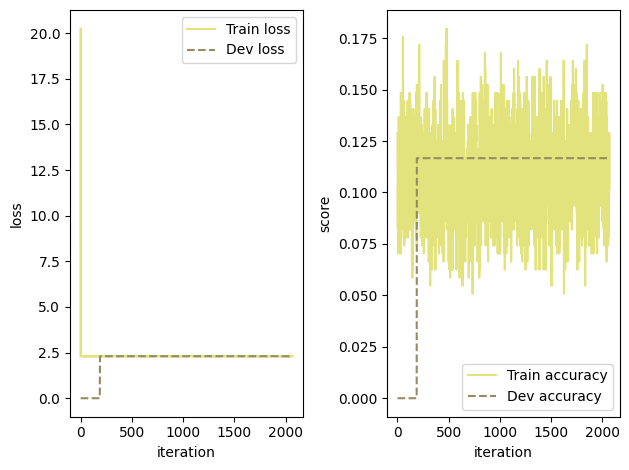

In [8]:
np.random.seed(309)
torch.manual_seed(309)

train_images_path = r'/home/user79/codes/dataset/MNIST/train-images-idx3-ubyte.gz'
train_labels_path = r'/home/user79/codes/dataset/MNIST/train-labels-idx1-ubyte.gz'

with gzip.open(train_images_path, 'rb') as f:
    magic, num, rows, cols = unpack('>4I', f.read(16))
    train_imgs = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28)

with gzip.open(train_labels_path, 'rb') as f:
    magic, num = unpack('>2I', f.read(8))
    train_labs = np.frombuffer(f.read(), dtype=np.uint8)

train_imgs = np.expand_dims(train_imgs, axis=1)
train_imgs = np.pad(train_imgs, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
train_imgs = train_imgs.astype(np.float32) / 255.0

idx = np.random.permutation(np.arange(num))
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:12000]
valid_labs = train_labs[:12000]
train_imgs = train_imgs[12000:]
train_labs = train_labs[12000:]

model = Model_LeNet(in_channels=1, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.99), eps=1e-7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[800, 2400, 4000], gamma=0.2)

runner = RunnerM_c(model, optimizer, accuracy, loss_fn, scheduler=scheduler, batch_size=256)

save_dir = r'/home/user79/codes/best_models/model_lenet_torch'

runner.train([train_imgs, train_labs], [valid_imgs, valid_labs], num_epochs=50, log_iters=100, save_dir=save_dir, patience=10)

_, axes = plt.subplots(1, 2)
axes = axes.reshape(-1)
_.set_tight_layout(1)
plot(runner, axes)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
image_path = os.path.join(save_dir, 'training_plot.png')
plt.savefig(image_path)

plt.show()

epoch: 0, iteration: 0
[Train] loss: 2.300072193145752, score: 0.12890625
epoch: 0, iteration: 100
[Train] loss: 0.17981155216693878, score: 0.94140625
epoch: 0 is over
[Train] loss: 0.12803253531455994, score: 0.953125
[Dev] loss: 0.11328694969415665, score: 0.965749979019165
best accuracy performance has been updated: 0.00000 --> 0.96575
epoch: 1, iteration: 0
[Train] loss: 0.10479675978422165, score: 0.95703125
epoch: 1, iteration: 100
[Train] loss: 0.04251757636666298, score: 0.984375
epoch: 1 is over
[Train] loss: 0.07603010535240173, score: 0.96875
[Dev] loss: 0.10205462574958801, score: 0.9695000052452087
best accuracy performance has been updated: 0.96575 --> 0.96950
epoch: 2, iteration: 0
[Train] loss: 0.08829274773597717, score: 0.9765625
epoch: 2, iteration: 100
[Train] loss: 0.051627267152071, score: 0.984375
epoch: 2 is over
[Train] loss: 0.04311395436525345, score: 0.984375
[Dev] loss: 0.05845668539404869, score: 0.9825000166893005
best accuracy performance has been updat

/tmp/ipykernel_637305/3089167030.py:93: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df.to_excel(excel_path, index=False)


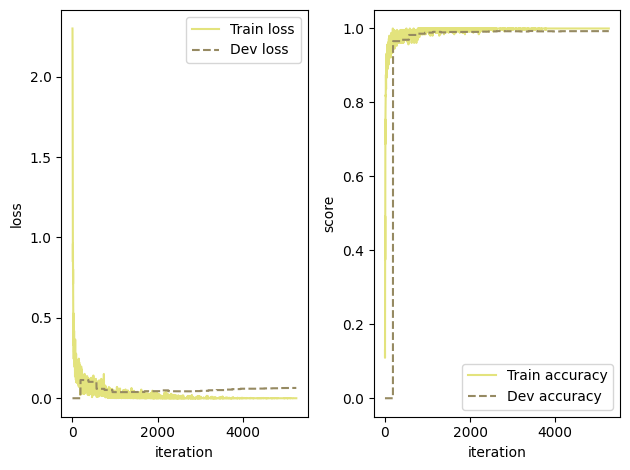

In [9]:
np.random.seed(309)
torch.manual_seed(309)

train_images_path = r'/home/user79/codes/dataset/MNIST/train-images-idx3-ubyte.gz'
train_labels_path = r'/home/user79/codes/dataset/MNIST/train-labels-idx1-ubyte.gz'

with gzip.open(train_images_path, 'rb') as f:
    magic, num, rows, cols = unpack('>4I', f.read(16))
    train_imgs = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28)

with gzip.open(train_labels_path, 'rb') as f:
    magic, num = unpack('>2I', f.read(8))
    train_labs = np.frombuffer(f.read(), dtype=np.uint8)

train_imgs = np.expand_dims(train_imgs, axis=1)
train_imgs = np.pad(train_imgs, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
train_imgs = train_imgs.astype(np.float32) / 255.0

idx = np.random.permutation(np.arange(num))
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:12000]
valid_labs = train_labs[:12000]
train_imgs = train_imgs[12000:]
train_labs = train_labs[12000:]

model = Model_LeNet(in_channels=1, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[800, 2400, 4000], gamma=0.2)

runner = RunnerM_c(model, optimizer, accuracy, loss_fn, scheduler=scheduler, batch_size=256)

save_dir = r'/home/user79/codes/best_models/model_lenet_torch'

runner.train([train_imgs, train_labs], [valid_imgs, valid_labs], num_epochs=50, log_iters=100, save_dir=save_dir, patience=10)

_, axes = plt.subplots(1, 2)
axes = axes.reshape(-1)
_.set_tight_layout(1)
plot(runner, axes)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
image_path = os.path.join(save_dir, 'training_plot.png')
plt.savefig(image_path)

plt.show()

In [5]:
model = Model_LeNet()
model.load_model(r'/home/user79/codes/best_models/model_lenet_torch_converge/best_model.pth')  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_images_path = r'/home/user79/codes/dataset/MNIST/t10k-images-idx3-ubyte.gz'
test_labels_path = r'/home/user79/codes/dataset/MNIST/t10k-labels-idx1-ubyte.gz'

with gzip.open(test_images_path, 'rb') as f:
    magic, num, rows, cols = unpack('>4I', f.read(16))
    test_imgs = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28)

with gzip.open(test_labels_path, 'rb') as f:
    magic, num = unpack('>2I', f.read(8))
    test_labs = np.frombuffer(f.read(), dtype=np.uint8)


test_imgs = np.expand_dims(test_imgs, axis=1)
test_imgs = np.pad(test_imgs, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
test_imgs = test_imgs.astype(np.float32) / 255.0

test_imgs = torch.from_numpy(test_imgs).float().to(device)
test_labs = torch.from_numpy(test_labs).long().to(device)

with torch.no_grad():
    logits = model(test_imgs)

acc = accuracy(logits, test_labs)
print(f"Test accuracy: {acc}")

/tmp/ipykernel_1654170/4169873107.py:23: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  test_labs = torch.from_numpy(test_labs).long().to(device)


Test accuracy: 0.9930999875068665


## Resnet with Pytorch

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu2(out)
        return out


class Model_ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(16, blocks=2, stride=1)
        self.layer2 = self._make_layer(32, blocks=2, stride=2)
        self.layer3 = self._make_layer(64, blocks=2, stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=4, stride=1)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if self.in_channels != out_channels or stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  
        x = self.fc(x)
        return x

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    def load_model(self, file_path):
        self.load_state_dict(torch.load(file_path))

epoch: 0, iteration: 0
[Train] loss: 2.435621738433838, score: 0.1171875
epoch: 0, iteration: 100
[Train] loss: 0.14683371782302856, score: 0.94140625
epoch: 0 is over
[Train] loss: 0.07565842568874359, score: 0.984375
[Dev] loss: 0.08014263212680817, score: 0.9750833511352539
best accuracy performance has been updated: 0.00000 --> 0.97508
epoch: 1, iteration: 0
[Train] loss: 0.09468869864940643, score: 0.9765625
epoch: 1, iteration: 100
[Train] loss: 0.05904873088002205, score: 0.97265625
epoch: 1 is over
[Train] loss: 0.08842390775680542, score: 0.9765625
[Dev] loss: 0.049713075160980225, score: 0.984416663646698
best accuracy performance has been updated: 0.97508 --> 0.98442
epoch: 2, iteration: 0
[Train] loss: 0.08333875983953476, score: 0.97265625
epoch: 2, iteration: 100
[Train] loss: 0.025940755382180214, score: 0.98828125
epoch: 2 is over
[Train] loss: 0.016858065500855446, score: 1.0
[Dev] loss: 0.05801284685730934, score: 0.9826666712760925
epoch: 3, iteration: 0
[Train] loss

/tmp/ipykernel_3138333/3089167030.py:93: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df.to_excel(excel_path, index=False)


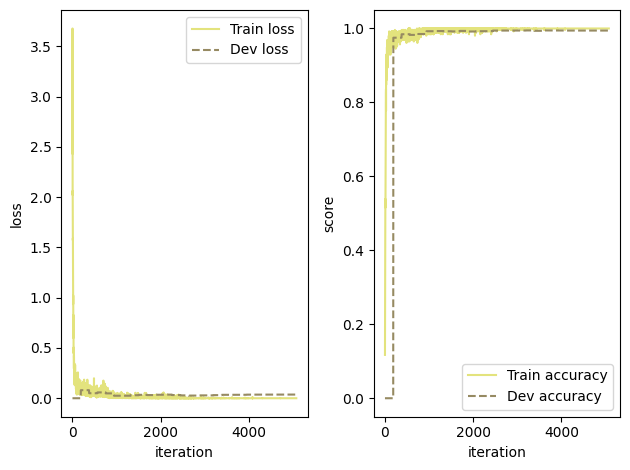

In [7]:
np.random.seed(309)
torch.manual_seed(309)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_images_path = r'/home/user79/codes/dataset/MNIST/train-images-idx3-ubyte.gz'
train_labels_path = r'/home/user79/codes/dataset/MNIST/train-labels-idx1-ubyte.gz'


with gzip.open(train_images_path, 'rb') as f:
    magic, num, rows, cols = unpack('>4I', f.read(16))
    train_imgs = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28*28)

with gzip.open(train_labels_path, 'rb') as f:
    magic, num = unpack('>2I', f.read(8))
    train_labs = np.frombuffer(f.read(), dtype=np.uint8)


idx = np.random.permutation(np.arange(num))
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:12000]
valid_labs = train_labs[:12000]
train_imgs = train_imgs[12000:]
train_labs = train_labs[12000:]

train_imgs = train_imgs / 255.0
valid_imgs = valid_imgs / 255.0

train_imgs = train_imgs.reshape(-1, 1, 28, 28)
valid_imgs = valid_imgs.reshape(-1, 1, 28, 28)

model = Model_ResNet().to(device)
loss_fn = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.99), eps=1e-7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[800, 2400, 4000], gamma=0.2)

runner = RunnerM_c(model=model, optimizer=optimizer, metric=accuracy, loss_fn=loss_fn, scheduler=scheduler, batch_size=256)

save_dir = r'/home/user79/codes/best_models/model_resnet_torch'

runner.train([train_imgs, train_labs], [valid_imgs, valid_labs], num_epochs=50, log_iters=100, save_dir=save_dir, patience=10)

_, axes = plt.subplots(1, 2)
axes = axes.reshape(-1)
_.set_tight_layout(1)
plot(runner, axes)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
image_path = os.path.join(save_dir, 'training_plot.png')
plt.savefig(image_path)

plt.show()

In [8]:
model = Model_ResNet()
model.load_model(r'/home/user79/codes/best_models/model_resnet_torch/best_model.pth')  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_images_path = r'/home/user79/codes/dataset/MNIST/t10k-images-idx3-ubyte.gz'
test_labels_path = r'/home/user79/codes/dataset/MNIST/t10k-labels-idx1-ubyte.gz'

with gzip.open(test_images_path, 'rb') as f:
    magic, num, rows, cols = unpack('>4I', f.read(16))
    test_imgs = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28)

with gzip.open(test_labels_path, 'rb') as f:
    magic, num = unpack('>2I', f.read(8))
    test_labs = np.frombuffer(f.read(), dtype=np.uint8)


test_imgs = np.expand_dims(test_imgs, axis=1)
test_imgs = test_imgs.astype(np.float32) / 255.0

test_imgs = torch.from_numpy(test_imgs).float().to(device)
test_labs = torch.from_numpy(test_labs).long().to(device)

with torch.no_grad():
    logits = model(test_imgs)

acc = accuracy(logits, test_labs)
print(f"Test accuracy: {acc}")

Test accuracy: 0.9928999543190002
